# Modelos SARIMA das variáveis de processo

A fundamentação teórica das abordagens apresentadas neste relatório está documentada na dissertação **Modelagem da pressão e da temperatura do molde em um processo de moldagem por injeção**, cujos estudos foram realizados no Grupo de Pesquisa em Manufatura Auxiliada por Computador (GPCAM). A mesma pode ser encontrada no repositório institucional da Universidade Federal de Santa Catarina (UFSC):

https://repositorio.ufsc.br/handle/123456789/230949

Os dados experimentais foram amostrados em um processo de moldagem por injeção durante a fabricação de peças de polipropileno H105. A pressão na cavidade e a temperatura em inserções no molde (à 10 mm da cavidade) foram medidas por meio de um sensor piezelétrico Kistler 6190CA e de termopares do tipo K, respectivamente. Devidos às limitações dos sensores, essas observações foram sujeitas a incertezas de $\pm$2,5 bar e $\pm$2,0 $^\circ$C.

O processo foi reproduzido em três condições experimentais distintas, variando a duração da etapa de preenchimento. A duração dessa é determinada pelo tempo que a rosca recíproca leva da posição inicial até a posição final de seu curso. Logo, processos com duração menor envolvem velocidades mais altas e vice-versa. As três condições experimentais são dadas por: I) 0,5, II) 1,0 e III) 2,0 segundos.

Neste relatório, as variáveis supracitadas são chamadas (de maneira genérica) como variáveis de processo. Essas foram salvas em arquivos com extensão .txt e acessadas nos scripts a seguir através da função *numpy.loadtxt()*. O exemplo a seguir mostra a obtenção das medições de um dos termopares em um processo do tipo I. Essas medições são ordenadas de maneira sequencial e o intervalo de tempo (intervalo de amostragem) entre essas é constante, com período de 0,184 segundos. Logo, o array *x* contém uma série temporal discreta da temperatura medida pelo termopar 1.

In [37]:
import numpy as np

x = np.loadtxt('temperature1_05s.txt', dtype = np.float64, usecols=[0])

As séries temporais das variáveis de processo não são estacionárias. As mesmas apresentam comportamentos sazonais devido à natureza cíclica do processo. Esta condição de não-estacionariedade impede a identificação do processo através de modelos autorregressivos de médias móveis. Esta dificuldade foi superada através do método de Box e Jenkins, que emprega a diferenciação de ordem sazonal das séries temporais.

As funções *difference()* e *i_difference()* implementam a diferenciação e a operação inversa à essa última. A diferenciação de ordem sazonal *s* (onde *s* é a duração do ciclo de moldagem em intervalos de amostras) remove o comportamento não-estacionário da série temporal. Logo, esta resulta em uma série temporal estacionária apenas com comportamentos autorregressivos e de médias móveis.

Também foi definida uma função para substituir amostras discrepantes pela média dos valores vizinhos na série temporal. Esta abordagem foi adotada pois essas amostras prejudicam a obtenção de modelos regressivos.

In [38]:
from scipy.stats import zscore

def difference(x, s):
    return x[s:x.size] - x[0:(x.size - s)]

def i_difference(x, y):
    x_ = y + x[0:y.size]
    x_ = np.append(x[0:(x.size - y.size)], x_)
    return x_

def replace_outliers(x, std):
    x_ = x.copy()
    z_scores = np.abs(zscore(x))

    for i in range(1, x.size - 1):
        if(z_scores[i] > std):
            x_[i] = (x_[i + 1] + x_[i - 1])/2
            
    return x_

Os ciclos de moldagem do processo I têm duração de 92 intervalos de amostragem. Logo, a série temporal da temperatura do molde foi submetida a diferenciação de ordem sazonal *s = 92*. Além disso, pontos discrepantes com incidência além de quatro desvios-padrão (valores maiores ou menores do que 99,99% das demais observações) foram substituídos pela função *replace_outliers()*.

In [39]:
s = 92

y = difference(x, s)
y = replace_outliers(y, 4)

O array *y* contém a série temporal diferenciada da temperatura do molde, destinada a modelagem do processo. Porém, antes disso, a série temporal foi particionada a fim de obter um conjunto de dados para treinar o modelo e um conjunto de dados para validá-lo.

A validação foi baseada nos dois últimos intervalos sazonais da série temporal diferenciada. Logo, a grandeza *2s* foi subtraída do tamanho do array *y*. A célula a seguir apresenta a partição do array *y* de modo a obter o array *y_train*, usado para treinar o modelo.

In [40]:
training_size = y.size - 2*s
y_train = y[0:training_size]

A série temporal diferenciada pode apresentar dinâmicas de ordem simples ou sazonal. Em dinâmicas de ordem simples, o valor atual da variável de processo está relacionado aos valores imediatamente anteriores da mesma e aos valores imediatamente anteriores da série de resíduos do modelo. Isso ocorre por comportamentos autorregressivos e de médias móveis, respectivamente. Já em dinâmicas de ordem sazonal o valor atual está relacionado a valores defasados por intervalos sazonal (i. e., em ciclos anteriores).

As funções de autocorrelação da amostra e de autocorrelação parcial podem ser usadas para determinar as ordens destas dinâmicas. Nota-se que a autocorrelação da amostra apresenta decaimento exponencial para defasagens baixas e um pico em torno de *h* = 92. Já a autocorrelação parcial tem uma queda abrupta após *h* = 1 e um pico em *h* = 92. Isto pode sugerir um comportamento autogressivo de ordem *p* = 1 e um comportamento autorregressivo de ordem sazonal *P* = 1. Não há indícios de comportamentos de médias móveis.


Autocorrelação da série temporal diferenciada:



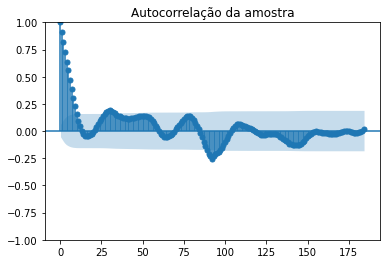

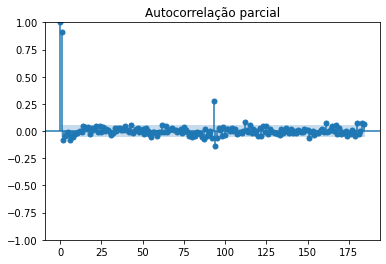

In [41]:
import statsmodels.api as sm
from matplotlib import pyplot as plt

print('\nAutocorrelação da série temporal diferenciada:\n')

fig = sm.graphics.tsa.plot_acf(y_train, lags = 2*s,
                                title = 'Autocorrelação da amostra')
plt.show()

fig = sm.graphics.tsa.plot_pacf(y_train, lags = 2*s,
                                    title = 'Autocorrelação parcial',
                                    method = 'yw')
plt.show()

O exame visual das figuras acima fornece a hipótese correspondente ao modelo SARIMA$(1, 0, 0)\times(1, 1, 0)_{92}$. A etapa seguinte da modelagem corresponde a estimativa dos coeficientes dos operadores autorregressivos e de médias móveis. Todavia, a hipótese anterior é rejeitada após o diagnóstico dos resíduos do modelo.

A identificação através do modelo SARIMA$(1, 0, 0)\times(1, 1, 0)_{92}$ não foi apresentada neste relatório com a intenção de mantê-lo breve. Mas é possível mencionar que a autocorrelação da amostra dos resíduos apresenta comportamentos autorregressivos de ordem *p* = 3 e comportamentos autorregressivos de ordem sazonal *P* = 2. Logo, o modelo possui incertezas não estruturadas e uma nova hipótese deve ser formulada.

A inclusão das dinâmicas não modeladas fornece o modelo SARIMA$(3, 0, 0)\times(2, 1, 0)_{92}$. Como será mostrado a seguir, esse é adequado à identificação do processo. Nos casos em que a hipótese alternativa não é adequada, é possível obter novas hipóteses através do procedimento descrito anteriormente.

A identificação dos coeficientes dos operadores lineares requer que um conjunto de parâmetros iniciais seja atribuído ao modelo. Este trabalho empregou valores pseudoaleatórios em tal inicialização. Na célula abaixo, as variáveis *q* e *Q* armazenam as ordens dos operadores de média móvel e de média móvel de ordem sazonal, respectivamente. O array *theta*, por sua vez, contém os valores iniciais dos coeficientes dos operadores lineares do modelo SARIMA.

In [42]:
(p, q, P, Q) = (3, 0, 2, 0)
order, seasonal_order = np.array([p, q]), np.array([P, Q, s])

theta = np.random.rand(p + q + P + Q + 2)

A biblioteca *statsmodels* contém uma classe respectiva ao modelo SARIMA. Contudo essa não foi utilizada neste trabalho, já que a mesma tem custo computacional excessivo (dependendo da ordem do modelo). Isso ocorre porque a regressão linear é baseada na maximização de uma função de verossimilhança, e para tanto a biblioteca *statsmodels* calcula a matriz Hessiana dessa função para verificar um determinado conjunto de parâmetros corresponde a um máximo global.

Este trabalho também estimou os parâmetros do modelo SARIMA através da maximização de uma função de verossimilhança. Porém o método de Nelder-Mead foi empregado a fim de reduzir o custo computacional relacionado ao cálculo de matrizes Hessianas. Como as funções da biblioteca *statsmodels* não foram utilizadas, os operadores do modelo SARIMA tiveram que ser representados de outra maneira.

As funções a seguir fornecem os operadores lineares em termos de instâncias da classe *Polynomial*. A função *operator()* retorna o polinômio de um operador, dados os parâmetros e a ordem do mesmo, enquanto a função *sarima_operators()* calcula todos os operadores do modelo através de chamadas da função anterior.

In [43]:
from numpy.polynomial import Polynomial

def operator(theta, order, interval = 1):
    if(order > 0):
        coef = np.zeros(interval*order + 1)
        coef[0] = 1
        
        for i in range(1, theta.size + 1):
            coef[i*interval] = theta[i - 1]  
    else:
        coef = 1
    return Polynomial(coef)

def sarima_operators(theta, order, seasonal_order):
    tmp = order[0]

    ar = operator(theta[0:tmp], order[0])
    ma = operator(theta[tmp:(tmp + order[1])], order[1])
    tmp += order[1]
    
    sar = operator(theta[tmp:(tmp + seasonal_order[0])],
                 seasonal_order[0], interval = seasonal_order[-1])
    tmp = tmp + seasonal_order[0]
    sma = operator(theta[tmp:(tmp + seasonal_order[1])],
                 seasonal_order[1], interval = seasonal_order[-1])
    
    return ar, ma, sar, sma

As funções abaixo foram definidas para auxiliar na visualização dos operadores. A função *plot_sarima_operators()* exibe a equação polinomial de um operador. As funções *superscript()* e *return_signal()* são funções auxiliares usadas para exibir caracteres sobrescritos e retornar o sinal de um determinado coeficiente.

In [44]:
def superscript(n):
    return ''.join(['⁰¹²³⁴⁵⁶⁷⁸⁹'[ord(c)-ord('0')] for c in str(n)])

def return_signal(x):
    if(np.sign(x) > 0):
        return '+'
    else:
        return '-'
    
def plot_sarima_operators(op, op_name):
    op = op.coef
    print(op_name + '(z) = ', end = '')
    for i in range(op.size):
        if(op[i] != 0):
            if(i != 0):
                print(return_signal(op[i]), end = '')
            if((op.size - i - 1) == 0):
                print(str(np.abs(round(op[i], 3))))
            else:
                print(str(np.abs(np.round(op[i], 3))) + 'z' + superscript(
                    op.size - i - 1), end = '')

As funções supracitadas são executadas na célula a seguir, apresentando as equações polinomiais do modelo SARIMA$(3, 0, 0)\times(2, 1, 0)_{92}$. Entretanto os coeficientes dessas ainda não correspondendo aos parâmetros verdadeiros do modelo da temperatura do molde.

In [45]:
lin_op = ['AR', 'MA', 'SAR', 'SMA']
res = sarima_operators(theta, order, seasonal_order)

print('\nOperadores autorregressivos e de médias móveis:\n')

for i in range(4):
    plot_sarima_operators(res[i], lin_op[i])


Operadores autorregressivos e de médias móveis:

AR(z) = 1.0z³+0.199z²+0.171z¹+0.939
MA(z) = 1.0
SAR(z) = 1.0z¹⁸⁴+0.909z⁹²+0.563
SMA(z) = 1.0


A maximização da função de verossimilhança fornece um conjunto de parâmetros que converge (por iteração) para o verdadeiro conjunto de parâmetros do modelo. Logo, essa pode ser entendida como a função de custo do respectivo problema de otimização.

Neste trabalho, a função de custo *mlp_regression()* foi definida a fim de implementar o problema de otimização. Essa retorna o valor negativo do logaritmo da função de verossimilhança. O logaritmo dessa é usado porque o cálculo da função de verossimilhança pode envolver a multiplicação de diversas probabilidades pequenas, resultando em instabilidades numéricas. Já o valor negativo é adotado para adaptar o problema ao método de Nelder-Mead.

A função *sarima_est()* estima os valores da série temporal, dado um conjunto de parâmetros e as ordens dos modelos. Além disso, a função retorna a série de resíduos e a maior ordem (entre os operadores autorregressivo *AR* e de média móvel *MA*) do modelo SARIMA.

In [46]:
from scipy.stats import norm

def sarima_est(theta, order, seasonal_order, y):
    intercept = theta[-2]
    
    ar, ma, sar, sma = sarima_operators(theta, order, seasonal_order)
    
    AR = ar*sar
    MA = ma*sma
    
    ar_index = np.nonzero(AR.coef)[0]
    ar_coef = AR.coef[AR.coef != 0]

    ma_index = np.nonzero(MA.coef)[0]
    ma_coef = MA.coef[np.abs(MA.coef) > 0]
    
    r = np.max([np.max(ar_index), np.max(ma_index)])
    
    y_est = y.copy()
    a = np.zeros(y.size)
    
    for i in range(r, y.size):
        y_est[i] = intercept
        
        if(ar_index.size > 1):
            for j in range(1, ar_index.size):
                y_est[i] += -ar_coef[j]*y[i - ar_index[j]]
        
        if(ma_index.size > 1):
            for j in range(1, ma_index.size):
                y_est[i] += ma_coef[j]*a[i - ma_index[j]]
                
        a[i] = y[i] - y_est[i]
        
    return y_est[r:y_est.size], a[r:a.size], r

def mlp_regression(theta, order, seasonal_order, y):
    y_est, a, r = sarima_est(theta, order, seasonal_order, y)
    sd = theta[-1]
    negLL = -np.sum(norm.logpdf(y[r:y.size], loc=y_est, scale= sd))
    return negLL

O método de Nelder-Mead calcula os valores da função de custo nos vértices de uma entidade geométrica denominada simplex. Essa se trata de uma generalização de triângulos (bidimensional) ou tetraedros (tridimensional) a espaços com dimensões adicionais. Após o cálculo da função de custo, a posição do vértice com o maior valor é alterada de modo a contrair o simplex. O procedimento continua até que um critério de convergência seja satisfeito.

A célula abaixo realiza a otimização, definindo o gradiente da função de custo como critério de parada. A convergência é assumida quando esse valor é inferior ao valor do parâmetro *xtol*. Os resultados mostram que isso ocorre após aproximadamente mil iterações.

In [47]:
from scipy.optimize import minimize

theta = minimize(mlp_regression, theta, args = (order, seasonal_order, y_train),
               method = 'Nelder-Mead',
               options={'xtol': 1e-10, 'disp': True, 'maxiter': 1e5}).x

Optimization terminated successfully.
         Current function value: -831.957506
         Iterations: 1279
         Function evaluations: 1995


Após a estimativa dos parâmetros do modelo é possível obter as equações polinomiais dos operadores lineares.

In [48]:
res = sarima_operators(theta, order, seasonal_order)

print('\nOperadores autorregressivos e de médias móveis:\n')

for i in range(4):
    plot_sarima_operators(res[i], lin_op[i])


Operadores autorregressivos e de médias móveis:

AR(z) = 1.0z³-1.052z²+0.071z¹+0.091
MA(z) = 1.0
SAR(z) = 1.0z¹⁸⁴+0.333z⁹²+0.172
SMA(z) = 1.0


De maneira análoga, as estimativas e os resíduos do modelo SARIMA$(3, 0, 0)\times(2, 1, 0)_{92}$ são dados pela função *sarima_est()*.

In [49]:
y_est, a, r = sarima_est(theta, order, seasonal_order, y)
a_train, a_val = a[0:(a.size - 2*s)], a[(a.size - 2*s):a.size]

É possível verificar que os resíduos são aleatórios por meio da autocorrelação da amostra. Esses se mantém bastante próximos do intervalo de confiança ao longo de dois intervalos sazonais.


Autocorrelação dos resíduos:



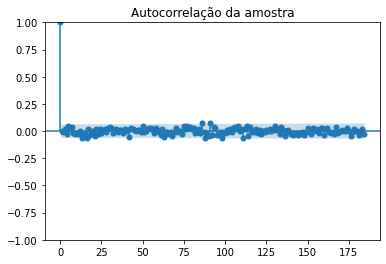

In [50]:
print('\nAutocorrelação dos resíduos:\n')

fig = sm.graphics.tsa.plot_acf(a_train, lags = 2*s,
                                title = 'Autocorrelação da amostra')
plt.show()

Todavia o exame visual da autocorrelação da amostra não é suficiente como teste estatístico da hipótese de aleatoriedade. Por esse motivo, o teste de Ljung-Box costuma ser empregado junto ao procedimento anterior. Esse teste avalia a adequação do modelo através do cálculo de uma estatística baseada na autocorrelação da amostra. A hipótese de que o modelo é adequado é rejeitada quando o valor p dessa estatística é inferior a 0,05.

A figura abaixo compreende os resultados do teste de Ljung-Box ao longo de dois intervalos sazonais. Observa-se que a adequação do modelo não foi rejeitada. Isso corrobora a hipótese de aleatoriedade dos resíduos.


Teste de Ljung-Box:



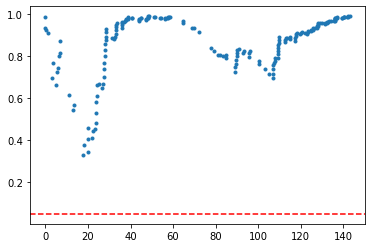

In [51]:
def plot_ljung_box(a, s):
    print('\nTeste de Ljung-Box:\n')
    
    res = sm.stats.acorr_ljungbox(a, lags = 2*s)
    
    fig = plt.figure()
    plt.plot(res.lb_stat, res.lb_pvalue, '.')
    plt.axhline(y = .05, color = 'r', linestyle = '--')
    plt.show()

plot_ljung_box(a_train, s)

Embora os resíduos sejam aleatórios, a distribuição dos mesmos não é normal. A população apresenta excesso positivo de curtose e assimetria negativa. O teste de Jarque-Bera foi empregado para testar a hipótese de normalidade. Assim como o teste de Ljung-Box, este rejeita a hipótese nula quando o valor p da estatística (dada em função do excesso de curtose e da assimetria da amostra) é menor que 0,05.

O valor p obtido foi aproximadamente nulo, resultando na rejeição da hipótese de normalidade. Logo, o desvio-padrão da amostra não é uma medida confiável da dispersão dos resíduos. Sendo assim, outra métrica deve ser usada para estabelecer o intervalo de confiança das estimativas do modelo da temperatura do molde.

In [52]:
from scipy.stats import skew, kurtosis, jarque_bera

def print_stats(a):
    print('\nValor esperado:', round(np.mean(a), 3),
          '\nVariância:', round(np.var(a), 3),
          '\nCurtose:', round(kurtosis(a), 3),
          '\nAssimetria:', round(skew(a), 3),
          '\nTeste de Jarque-Bera (valor p)', round(jarque_bera(a)[1], 3))

print_stats(a_train)


Valor esperado: -0.0 
Variância: 0.011 
Curtose: 14.22 
Assimetria: -0.458 
Teste de Jarque-Bera (valor p) 0.0


A amplitude interquartil pode ser usada para estimar a dispersão das amostras em situações em que a população não é normal. Essa é dada pela diferença entre os quartis superior e inferior da distribuição das amostras. Esses, por sua vez, correspondem aos valores que delimitam as frequências acumuladas de 25 e 75% das amostras.

O intervalo delimitado pelos valores Q(25%) - 1.5IQR e Q(75%) + 1.5IQR compreende 95% das amostras na população. Para o modelo SARIMA$(3, 0, 0)\times(2, 1, 0)_{92}$ da temperatura do molde, este intervalo vai de -0,186 a 0,194 $^\circ$C. 

In [53]:
def print_quartiles(a):
    Q1 = np.quantile(a, .25)
    Q3 = np.quantile(a, .75)
    IQR = Q3 - Q1
    
    a_inf = Q1 - 1.5*IQR
    a_sup = Q3 + 1.5*IQR

    print('\nQuartil inferior - Q(25%):', round(Q1, 3),
          '\nQuartil superior - Q(75%):', round(Q3, 3),
          '\nAmplitude interquartil:', round(IQR, 3),
          '\nQ(25%) - 1.5IQR:', round(a_inf, 3),
          '\nQ(75%) + 1.5IQR:', round(a_sup, 3))
    
    return a_inf, a_sup

a_inf, a_sup = print_quartiles(a_train)


Quartil inferior - Q(25%): -0.044 
Quartil superior - Q(75%): 0.051 
Amplitude interquartil: 0.095 
Q(25%) - 1.5IQR: -0.186 
Q(75%) + 1.5IQR: 0.194


Como mencionado anteriormente, a validação foi realizada para os dois últimos ciclos de moldagem. A série temporal diferenciada foi estimada pela função *sarima_est()* e uma estimativa da série temporal não-estacionária foi obtida através da função *i_difference()*. Após isso, essa última e a série de resíduos foram particionadas em seus dois últimos intervalos sazonais.

In [54]:
y_est = np.append(y[0:r], y_est)
x_est = i_difference(x, y_est)

x_val = x_est[(x_est.size - 2*s):x_est.size]
x = x[(x.size - 2*s):x.size]
t = .184*np.arange(a_val.size)

A dispersão calculada com base na amplitude interquartil foi usada para detectar pontos discrepantes entre as amostras.

In [55]:
indexes = (a_val > a_sup) | (a_val < a_inf)
(outliers_a, outliers_t, outliers_x) = (a_val[indexes], t[indexes], x[indexes])

As estimativas e a ocorrência de discrepâncias podem ser observadas na figura abaixo, junto as amostras medidas no molde. Nota-se que os erros de modelagem são bastante baixos, resultando em discrepâncias apenas durante as transições entre etapas da moldagem por injeção. Contudo essas anomalias podem ser facilmente entendidas, devido as mudanças abruptas no comportamento do processo nesses instantes.


Estimativas do modelo:



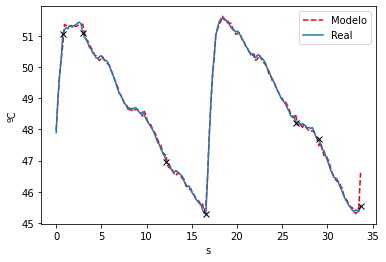

In [56]:
def plot_est(x, x_est, t, outliers_x, outliers_t, measure):
    print('\nEstimativas do modelo:\n')

    fig = plt.figure()
    plt.plot(t, x_est, 'r--', label = 'Modelo')
    plt.plot(t, x, label = 'Real')
    plt.plot(outliers_t, outliers_x, 'kx')
    plt.legend(loc='upper right', frameon=True)
    plt.xlabel('s')
    plt.ylabel(measure)
    plt.show()
    
plot_est(x, x_val, t, outliers_x, outliers_t, 'ºC')

A representação gráfica dos erros de modelagem mostra que a maior parte dos resíduos se encontra no intervalo de -0,186 a 0,194. Assim, é possível afirmar que o modelo tem desempenhos comparáveis no conjunto de treinamento e no conjunto de validação.


Erros de modelagem:



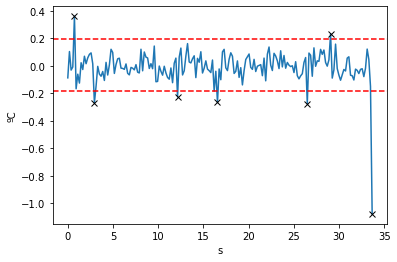

In [57]:
def plot_residues(a, t, a_inf, a_sup, outliers_a, outliers_t, measure):
    print('\nErros de modelagem:\n')

    fig = plt.figure()
    plt.plot(t, a)
    plt.axhline(y = a_inf, color = 'r', linestyle = '--')
    plt.axhline(y = a_sup, color = 'r', linestyle = '--')
    plt.plot(outliers_t, outliers_a, 'kx')
    plt.xlabel('s')
    plt.ylabel(measure)
    plt.show()
    
plot_residues(a_val, t, a_inf, a_sup, outliers_a, outliers_t, 'ºC')

Outrossim, a dispersão dos resíduos é bastante inferior à incerteza do termopar ($\pm$ 2,0 $^\circ$C), com exceção das anomalias observadas durante as transições entre etapas. Logo, a maioria dos erros de modelagem não podem ser experimentalmente comprovados.

A metodologia proposta pode ser empregada à outras variáveis de processo, sendo igualmente bem-sucedida. O exemplo a seguir a baseado na pressão na cavidade, também no processo I. Nesse caso, o logaritmo natural da pressão (transformação de Box-Cox) foi modelado ao invés da própria variável de processo.

Transformações de Box-Cox são necessárias quando a série temporal apresenta comportamentos não-lineares. A ocorrência desses na série temporal da pressão na cavidade no processo I pode ser explicada pela pseudoplasticidade do polímero fundido. Conforme a teoria do escoamento genérico, a viscosidade do polímero fundido decresce (a partir do regime Newtoniano inicial) à medida que a tensão de cisalhamento (a que esse é submetido) aumenta. Esse fenômeno induz comportamentos não-lineares no escoamento.

In [58]:
x = np.loadtxt('pressure1_05s.txt', dtype = np.float64, usecols=[0])
x = np.log(x)

y = difference(x, s)
y = replace_outliers(y, 4)

training_size = y.size - 2*s
y_train = y[0:training_size]

O exame visual das funções de autocorrelação da amostra e autocorrelação parcial demonstra que o processo tem comportamento majoritariamente autorregressivo com ordem *p* = 4. Portanto, é assumida a hipótese correspondente ao modelo SARIMA$(4, 0, 0)\times(0, 1, 0)_{92}$.


Autocorrelação da série temporal diferenciada:



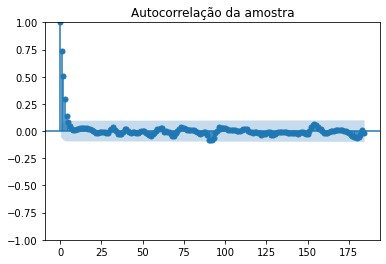

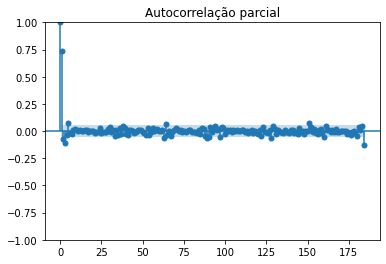

In [59]:
print('\nAutocorrelação da série temporal diferenciada:\n')

fig = sm.graphics.tsa.plot_acf(y_train, lags = 2*s,
                                title = 'Autocorrelação da amostra')
plt.show()

fig = sm.graphics.tsa.plot_pacf(y_train, lags = 2*s,
                                    title = 'Autocorrelação parcial',
                                    method = 'yw')
plt.show()

A maximização da função de verossimilhança converge após 638 iterações, resultando nos operadores apresentados a seguir.

In [60]:
(p, q, P, Q) = (4, 0, 0, 0)
order, seasonal_order = np.array([p, q]), np.array([P, Q, s])

theta = np.random.rand(p + q + P + Q + 2)
theta = minimize(mlp_regression, theta, args = (order, seasonal_order, y_train),
               method = 'Nelder-Mead',
               options={'xtol': 1e-10, 'disp': True, 'maxiter': 1e5}).x

res = sarima_operators(theta, order, seasonal_order)

print('\nOperadores autorregressivos e de médias móveis:\n')

for i in range(4):
    plot_sarima_operators(res[i], lin_op[i])

Optimization terminated successfully.
         Current function value: 229.037268
         Iterations: 638
         Function evaluations: 1052

Operadores autorregressivos e de médias móveis:

AR(z) = 1.0z⁴-0.766z³-0.011z²+0.075z¹+0.035
MA(z) = 1.0
SAR(z) = 1.0
SMA(z) = 1.0


O modelo SARIMA$(4, 0, 0)\times(0, 1, 0)_{92}$ é adequado, de acordo com a autocorrelação da amostra e com o teste de Ljung-Box dos resíduos.


Autocorrelação dos resíduos:



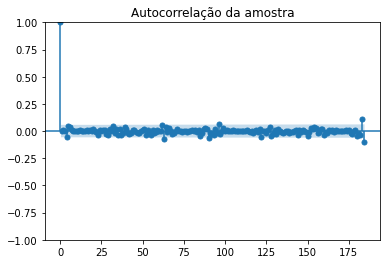


Teste de Ljung-Box:



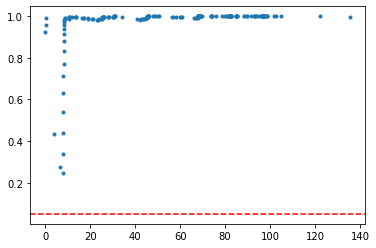

In [61]:
y_est, a, r = sarima_est(theta, order, seasonal_order, y)

a_train, a_val = a[0:(a.size - 2*s)], a[(a.size - 2*s):a.size]

print('\nAutocorrelação dos resíduos:\n')

fig = sm.graphics.tsa.plot_acf(a_train, lags = 2*s,
                                title = 'Autocorrelação da amostra')
plt.show()

plot_ljung_box(a_train, s)

Contudo a hipótese de normalidade foi rejeitada outra vez. A distribuição dos resíduos é leptocúrtica (excesso positivo) e assimétrica, resultando em um valor p (teste de Jarque-Bera) aproximadamente nulo. Por consequência, o intervalo de confiança das estimativas foi baseado na amplitude interquartil dos resíduos. Como é apresentado abaixo, 95% dos resíduos ocorrem entre -0,107 e 0,103 (em unidades de logaritmo de bar).

In [62]:
print_stats(a_train)
a_inf, a_sup = print_quartiles(a_train)


Valor esperado: -0.0 
Variância: 0.086 
Curtose: 50.64 
Assimetria: 1.306 
Teste de Jarque-Bera (valor p) 0.0

Quartil inferior - Q(25%): -0.028 
Quartil superior - Q(75%): 0.024 
Amplitude interquartil: 0.052 
Q(25%) - 1.5IQR: -0.107 
Q(75%) + 1.5IQR: 0.103


A validação do modelo foi reproduzida de maneira aproximadamente idêntica a apresentada no exemplo anterior. Entretanto as estimativas da variável de processo foram submetidas a exponenciação, pela função *numpy.exp()*, para inverter a transformação de Box-Cox.

In [63]:
y_est = np.append(y[0:r], y_est)
x_est = i_difference(x, y_est)

x_val = np.exp(x_est[(x_est.size - 2*s):x_est.size])
x = np.exp(x[(x.size - 2*s):x.size])
t = .184*np.arange(a_val.size)

indexes = (a_val > a_sup) | (a_val < a_inf)
(outliers_a, outliers_t, outliers_x) = (a_val[indexes], t[indexes], x[indexes])

As estimativas são bastante próximas dos valores reais, exceto pelos instantes correspondentes a transições entre etapas. No perfil de pressão as anomalias também ocorrem (com frequência) no instante em que o ponto de injeção é congelado.

Essas discrepâncias podem ser explicadas pela queda abrupta de pressão que o material na cavidade experimenta durante a etapa de resfriamento. A mesma é influenciada pela complacência do molde e pelo valor da pressão no início dessa etapa. 


Estimativas do modelo:



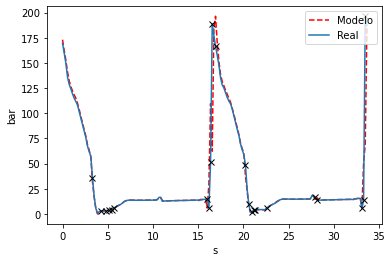

In [64]:
plot_est(x, x_val, t, outliers_x, outliers_t, 'bar')

O gráfico dos erros de modelagem auxilia na compreensão das estimativas discrepantes. Novamente a maioria dos erros de modelagem apresentou valores inferior à incerteza do sensor piezelétrico ($\pm$2,5 bar), exceto pelos erros de modelagem durante as transições.


Erros de modelagem:



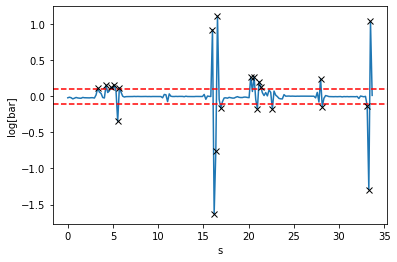

In [65]:
plot_residues(a_val, t, a_inf, a_sup, outliers_a, outliers_t, 'log[bar]')

Os exemplos anteriores apresentaram as linhas de código em células separadas para de explicar suas finalidades. Entretanto os próximos exemplos utilizarão a função *sarima_modelling()*, que emprega os scripts anteriores. A mesma requer o conhecimento da ordem do modelo e da necessidade de transformações de Box-Cox.

In [66]:
def sarima_modelling(x, s, order, seasonal_order, period, measure, box_cox = False):
    if(box_cox):
        x = np.log(x)
        
    y = replace_outliers(difference(x, s), 4)
    training_size = y.size - 2*s
    y_train = y[0:training_size]
    
    theta = np.random.rand(p + q + P + Q + 2)
    theta = minimize(mlp_regression, theta, args = (order, seasonal_order, y_train),
               method = 'Nelder-Mead',
               options={'xtol': 1e-10, 'disp': True, 'maxiter': 1e5}).x
    
    lin_op = ['AR', 'MA', 'SAR', 'SMA']
    res = sarima_operators(theta, order, seasonal_order)

    print('\nOperadores autorregressivos e de médias móveis:\n')

    for i in range(4):
        plot_sarima_operators(res[i], lin_op[i])
    
    y_est, a, r = sarima_est(theta, order, seasonal_order, y)
    a_train, a_val = a[0:(a.size - 2*s)], a[(a.size - 2*s):a.size]

    print('\nAutocorrelação dos resíduos:\n')

    fig = sm.graphics.tsa.plot_acf(a_train, lags = 2*s,
                                    title = 'Autocorrelação da amostra')
    plt.show()

    plot_ljung_box(a_train, s)
    print_stats(a_train)
    a_inf, a_sup = print_quartiles(a_train)

    x_est = i_difference(x, np.append(y[0:r], y_est))
    
    x_val = x_est[(x_est.size - 2*s):x_est.size]
    x = x[(x.size - 2*s):x.size]
    t = period*np.arange(a_val.size)
    
    if(box_cox):
        x_val, x = np.exp(x_val), np.exp(x)
        measure_ = 'log[' + measure + ']'
    else:
        measure_ = measure

    indexes = (a_val > a_sup) | (a_val < a_inf)
    (outliers_a, outliers_t, outliers_x) = (a_val[indexes], t[indexes], x[indexes])

    plot_est(x, x_val, t, outliers_x, outliers_t, measure)
    plot_residues(a_val, t, a_inf, a_sup, outliers_a, outliers_t, measure_)

A célula abaixo exemplifica o uso desta função para obter os resultados do modelo SARIMA$(2, 0, 2)\times(1, 1, 0)_{96}$ da pressão na cavidade em um processo do tipo II. As ordens dos operadores foram determinadas através do exame visual das funções de autocorrelação da amostra e autocorrelação parcial.

Não foram utilizadas transformações de Box-Cox neste exemplo, já que os comportamentos não-lineares são menos intensos. As tensões de cisalhamento são inferiores as que ocorrem no processo I e, portanto, é possível argumentar que comportamentos pseudoplásticos são menos frequentes. Logo, a relação entre taxa e tensão de cisalhamento é linear, pertencendo a região Newtoniana inicial.

A convergência dos parâmetros ocorreu após aproximadamente mil iterações, produzindo resíduos aleatórios conforme o teste de Ljung-Box. Embora a autocorrelação da amostra apresente pequenos picos sazonais de primeira ordem, é razoável afirmar que estes não indicam comportamentos autorregressivos ou de médias móveis. O modelo já apresenta um operador autorregressivo de ordem sazonal e a inclusão de um operador de média móvel de ordem sazonal não produz mudanças visíveis nos resultados.

A normalidade da distribuição dos resíduos foi rejeitada pelo teste de Jarque-Bera. Logo, o intervalo de confiança das estimativas foi baseado na amplitude interquartil dos resíduos. É possível afirmar que 95% dos resíduos ocorrem no intervalo de -0,892 a 0,885 bar (contido no intervalo correspondente aos erros experimentais). Como é possível observar nas estimativas do modelo e nos erros de modelagem, as discrepâncias ocorrem apenas nas transições entre as etapas da moldagem por injeção.

Optimization terminated successfully.
         Current function value: 1100.078300
         Iterations: 863
         Function evaluations: 1393

Operadores autorregressivos e de médias móveis:

AR(z) = 1.0z²-0.851z¹+0.21
MA(z) = 1.0z²+0.054z¹+0.084
SAR(z) = 1.0z⁹⁶+0.161
SMA(z) = 1.0

Autocorrelação dos resíduos:



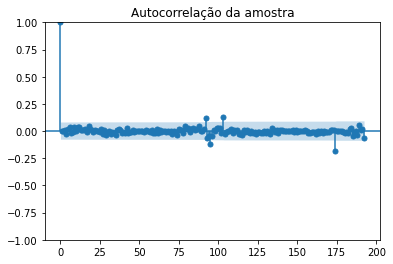


Teste de Ljung-Box:



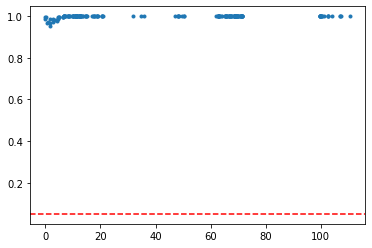


Valor esperado: 0.0 
Variância: 2.107 
Curtose: 233.124 
Assimetria: 11.655 
Teste de Jarque-Bera (valor p) 0.0

Quartil inferior - Q(25%): -0.231 
Quartil superior - Q(75%): 0.22 
Amplitude interquartil: 0.451 
Q(25%) - 1.5IQR: -0.908 
Q(75%) + 1.5IQR: 0.896

Estimativas do modelo:



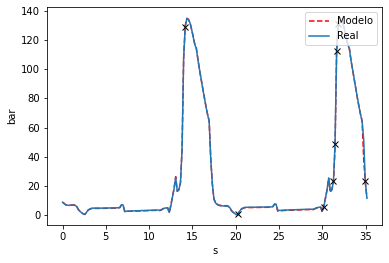


Erros de modelagem:



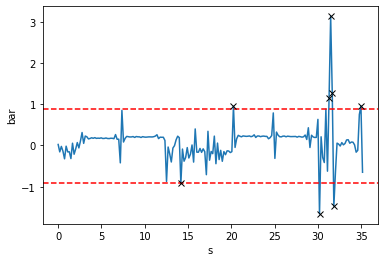

In [67]:
x = np.loadtxt('pressure1_1s.txt', dtype = np.float64, usecols=[0])[600:1600]

s = 96

(p, q, P, Q) = (2, 2, 1, 0)
order, seasonal_order = np.array([p, q]), np.array([P, Q, s])

sarima_modelling(x, s, order, seasonal_order, .184, 'bar')

O procedimento foi repetido para a temperatura do molde (termopar 2) do mesmo processo através do modelo SARIMA$(1, 0, 1)\times(1, 1, 0)_{96}$. A identificação exigiu menos iterações que no caso anterior, pois a ordem dos operadores lineares é menor. Assim como no caso anterior, os resíduos do modelo são aleatórios conforme o teste de Ljung-Box. O mesmo pode ser afirmado a respeito da autocorrelação da amostra, exceto pelo pico negativo em *h* = 96.

A inclusão de um operador de média móvel de ordem sazonal *Q* = 1 não produziu mudanças significativas nos resultados. Logo, não é possível atribuir o pico supracitado a um comportamento de média móvel não modelado. De fato, a autocorrelação da amostra é uma estimativa da função de autocorrelação da série temporal. Essa converge para a autocorrelação real conforme o número de amostras usadas na estimativa cresce. Assim, é possível supor que esse pico ocorre devido as limitações da estimativa (baseada em mil amostras).

O intervalo de -0,254 a 0,248 $^\circ$C compreende 95% dos resíduos, sendo usado como intervalo de confiança para as estimativas. Novamente, é possível dizer que os erros de modelagem são desprezíveis em face da incerteza das medições (de -2,0 a 2,0 $^\circ$C). As estimativas do modelo e os erros de modelagem demostram que as discrepâncias só ocorrem próximo à transições entre etapas (durante o rápido crescimento durante a etapa de preenchimento e ao fim da etapa de compressão).

Optimization terminated successfully.
         Current function value: -222.757684
         Iterations: 463
         Function evaluations: 795

Operadores autorregressivos e de médias móveis:

AR(z) = 1.0z¹-0.937
MA(z) = 1.0z¹-0.16
SAR(z) = 1.0z⁹⁶+0.335
SMA(z) = 1.0

Autocorrelação dos resíduos:



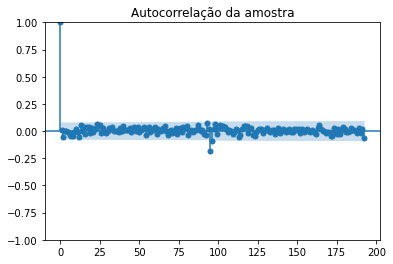


Teste de Ljung-Box:



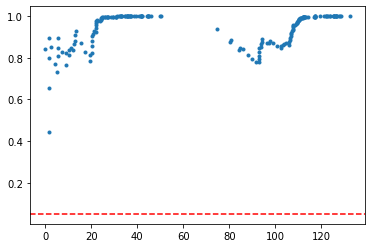


Valor esperado: 0.0 
Variância: 0.028 
Curtose: 47.542 
Assimetria: 1.515 
Teste de Jarque-Bera (valor p) 0.0

Quartil inferior - Q(25%): -0.065 
Quartil superior - Q(75%): 0.06 
Amplitude interquartil: 0.126 
Q(25%) - 1.5IQR: -0.254 
Q(75%) + 1.5IQR: 0.248

Estimativas do modelo:



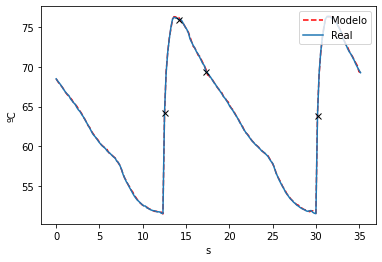


Erros de modelagem:



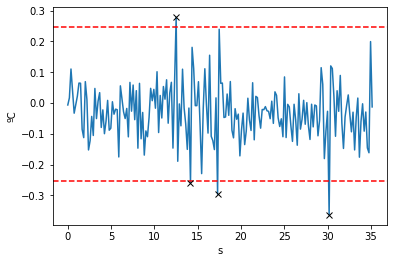

In [68]:
x = np.loadtxt('temperature2_1s.txt', dtype = np.float64, usecols=[0])[600:1600]

s = 96

(p, q, P, Q) = (1, 1, 1, 0)
order, seasonal_order = np.array([p, q]), np.array([P, Q, s])

sarima_modelling(x, s, order, seasonal_order, .184, 'ºC')

O último exemplo deste relatório apresenta o modelo SARIMA$(4, 0, 0)\times(1, 1, 0)_{111}$ da pressão na cavidade em um processo do tipo III. Neste caso não foi possível obter um modelo adequado ao processo. O modelo SARIMA$(4, 0, 0)\times(1, 1, 0)_{111}$ se trata apenas do modelo para o qual os resíduos quadráticos foram mínimos, em comparação com modelos alternativos dados por ordens $(p, d, q)\times(P, D, Q)_s$ diferentes.

É possível constatar que os resíduos do modelo não são aleatórios. Essa hipótese é rejeitada pelo exame visual da autocorrelação da amostra e a adequação do modelo pelo teste de Ljung-Box. A modificação do modelo, levando em conta a autocorrelação dos resíduos, não foi bem-sucedida. Logo, apesar das estimativas serem bastante próximas dos valores reais, não é possível determinar um intervalo de confiança que represente bem a dispersão dos resíduos.

As figuras contendo as estimativas do modelo e os erros de modelagem demonstram a situação mencionada acima. As amostras discrepantes ocorrem ao longo de todo o processo, mesmo quando o comportamento não é anômalo. Além disso, seus valores são bastante superiores ao erro experimental ($\pm$2,5 bar) em diversos momentos.

A razão da falha na identificação deste processo através de um modelo SARIMA é a não-sazonalidade do mesmo. Como é possível observar nas estimativas do modelo, em um dos ciclos as etapas de compressão e recalque são atípicas. É possível dizer o mesmo da etapa de resfriamento, já que a queda de pressão nessa depende da pressão na cavidade ao fim da etapa de recalque. A ausência de comportamentos compressíveis ocorre quando a cavidade não é volumetricamente preenchida ao fim da etapa de preenchimento.

Processos do tipo III se mostraram mais propensos à essas condições atípicas. Dois fenômenos podem contribuir para isso: 1) o comportamento não-linear do polímero fundido e 2) o crescimento da camada congelada no interior na cavidade. Como o processo III envolve velocidades menores, o decréscimo na viscosidade (devido ao comportamento pseudoplástico) é menos frequente. Assim, há mais resistência ao escoamento do polímero fundido para a cavidade. Já o crescimento da camada congelada incrementa a queda de pressão no escoamento, pois o confina a uma espessura menor conforme o processo avança. Essa situação diminui a vazão volumétrica para a cavidade do molde.

Os fenômenos 1 e 2 contribuiem para o preenchimento deficiente da cavidade. Como o processo III compreende tanto perfis de pressão típicos como atípicos, este não é sazonal e, portanto, ocorrem incertezas não-estruturadas quando um modelo SARIMA é empregado para identificar o processo.

Optimization terminated successfully.
         Current function value: 1461.169616
         Iterations: 1524
         Function evaluations: 2368

Operadores autorregressivos e de médias móveis:

AR(z) = 1.0z⁴-1.487z³+0.55z²-0.05z¹+0.029
MA(z) = 1.0
SAR(z) = 1.0z¹¹¹+0.269
SMA(z) = 1.0

Autocorrelação dos resíduos:



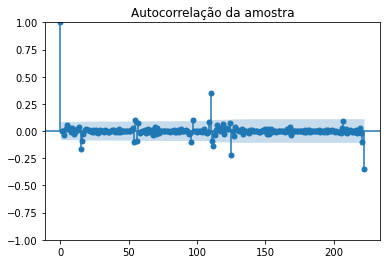


Teste de Ljung-Box:



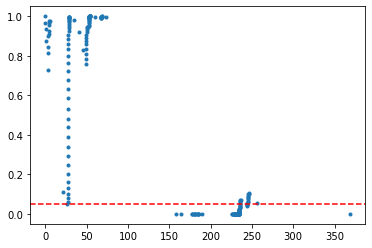


Valor esperado: -0.0 
Variância: 11.661 
Curtose: 48.01 
Assimetria: 0.719 
Teste de Jarque-Bera (valor p) 0.0

Quartil inferior - Q(25%): -0.12 
Quartil superior - Q(75%): 0.069 
Amplitude interquartil: 0.189 
Q(25%) - 1.5IQR: -0.403 
Q(75%) + 1.5IQR: 0.353

Estimativas do modelo:



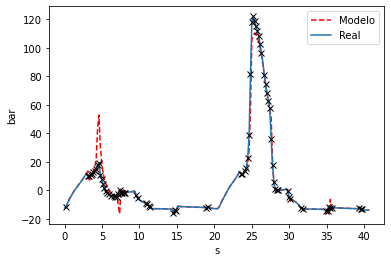


Erros de modelagem:



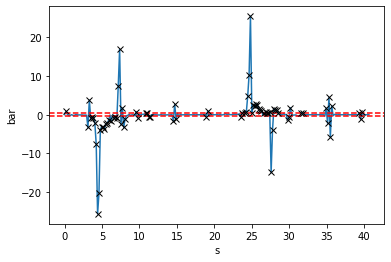

In [69]:
x = np.loadtxt('pressure1_2s.txt', dtype = np.float64, usecols=[0])[800:1800]

s = 111

(p, q, P, Q) = (4, 0, 1, 0)
order, seasonal_order = np.array([p, q]), np.array([P, Q, s])

sarima_modelling(x, s, order, seasonal_order, .184, 'bar')

Os exemplos exibidos ao longo deste relatório compõem parte do estado da arte nos estudos da moldagem por injeção no GPCAM. Propostas para trabalhos futuros incluem: 1) a modelagem de séries temporais obtidas em processos com configurações e materiais diferentes; 2) o monitoramento do processo em tempo real; 3) a obtenção de modelos relacionando as variáveis de processo às variáveis de máquina.